In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
from sklearn.metrics import mean_squared_error
import contextlib
import io
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
def read_file(location, pollutant):
  df_1 = pd.read_csv('drive/MyDrive/SMC/Data/' + location + '_2020.csv', skiprows = [0,1,4])
  df_2 = pd.read_csv('drive/MyDrive/SMC/Data/' + location + '_2021.csv', skiprows = [0,1,4])
  df_3 = pd.read_csv('drive/MyDrive/SMC/Data/' + location + '_2022.csv', skiprows = [0,1,4])
  df_4 = pd.read_csv('drive/MyDrive/SMC/Data/' + location + '_2023.csv', skiprows = [0,1,4])

  df = pd.concat([df_1, df_2, df_3, df_4])
  df = df[[pollutant]]
  df = df.dropna(axis = 0)

  return df

In [3]:
def to_supervised(train, window_size):
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i - window_size:i, :])
    Y.append(train[i, 0:1])
    
  return X, Y

In [4]:
def data_generating(df):
  values = df.values
  scaler = MinMaxScaler(feature_range = (0, 1))
  scaled_dataset = scaler.fit_transform(values)
  X, Y = to_supervised(scaled_dataset, window_size)
  X = np.array(X)
  Y = np.array(Y)

  n_train = int(0.8 * X.shape[0])
  n_test = int(X.shape[0]) - n_train
  X_train, X_test = X[:n_train,], X[n_train:,]
  Y_train, Y_test = Y[:n_train,], Y[n_train:,]

  return X, Y, X_train, Y_train, X_test, Y_test, n_train, n_test, scaler, scaled_dataset

In [5]:
def model_LSTM(X_train):
  model = Sequential()

  model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(0.2))

  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))

  model.add(LSTM(units = 50))
  model.add(Dropout(0.2))

  model.add(Dense(units = 1))
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  return model

In [6]:
def fit_model(X_train, Y_train, X_test, Y_test):
  output_stream = io.StringIO()
  with contextlib.redirect_stdout(output_stream):
    model.fit(X_train, Y_train, epochs = 20, batch_size = 32)
    Y_pred = model.predict(X_test)
  mse = mean_squared_error(Y_test, Y_pred)
  rmse = np.sqrt(mse)
  print('Root mean square error:', round(rmse, 4))

  return Y_pred

In [7]:
def scale_back(Y_test, Y_pred):
  d = scaled_dataset[:n_test, :]
  Y_predicted = np.concatenate((Y_pred, d[:n_test, 1:]), axis = 1)
  Y_tested = np.concatenate((Y_test, d[:n_test, 1:]), axis = 1)
  Y_predicted = scaler.inverse_transform(Y_predicted)
  Y_tested = scaler.inverse_transform(Y_tested)
  Y_predicted = Y_predicted[:, 0:1]
  Y_tested = Y_tested[:, 0:1]

  return Y_predicted, Y_tested

In [8]:
def plot_graph(Y_tested, Y_predicted, location, pollutant):
  #Plot the graph between actual vs predicted values
  plt.figure(figsize=(6, 4.5))
  plt.plot(Y_predicted[:n_test, :], color= 'green', label='Prediction')
  plt.plot(Y_tested[:n_test, :] , color = 'red', label='Ground truth')
  plt.title("Prediction in " + location)
  plt.xlabel("Days")
  plt.ylabel(pollutant)
  plt.legend()
  plt.tight_layout()
  plt.show()

In [9]:
def predict(X, Y):
  input = X
  output = Y
  prediction = []

  for i in range(days_predict):
    # we use the predicted value to be the input for the next prediction
    list_prediction = [[input[-1][j + 1].item()] for j in range(window_size - 1)]
    list_prediction.extend([[output[-1].item()]])
    input = np.array([list_prediction])

    # this is to remove unnecessary output
    output_stream = io.StringIO()
    with contextlib.redirect_stdout(output_stream):
      output = model.predict(input)
      prediction.append([output[-1].item()])

  return prediction

In [10]:
def scale_prediction(prediction):
  d = scaled_dataset[:days_predict,:]
  Y_predicted = np.concatenate((prediction, d[:days_predict, 1:]), axis = 1)
  Y_predicted = scaler.inverse_transform(Y_predicted)
  Y_predicted_future = Y_predicted[:, 0:1]

  return Y_predicted_future

In [11]:
def plot_prediction(location, pollutant, Y_predicted_future):
  plt.figure(figsize=(6, 4.5))
  plt.plot(Y_predicted_future, color= 'green', label=f"Prediction next {days_predict} days")
  plt.title("Prediction in " + location)
  plt.xlabel("Days")
  plt.ylabel(pollutant)
  scales = np.arange(0, days_predict + 1, 2)
  plt.xticks(scales)
  plt.legend()
  plt.tight_layout()
  plt.show()

Root mean square error: 0.1304


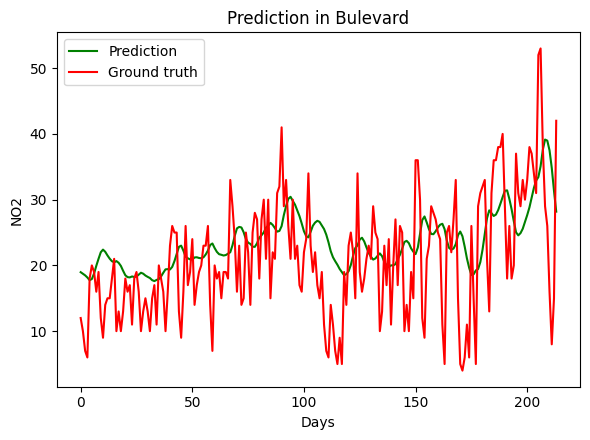

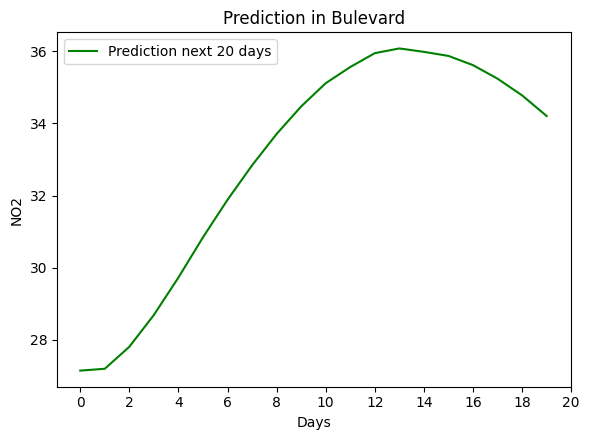

Root mean square error: 0.1436


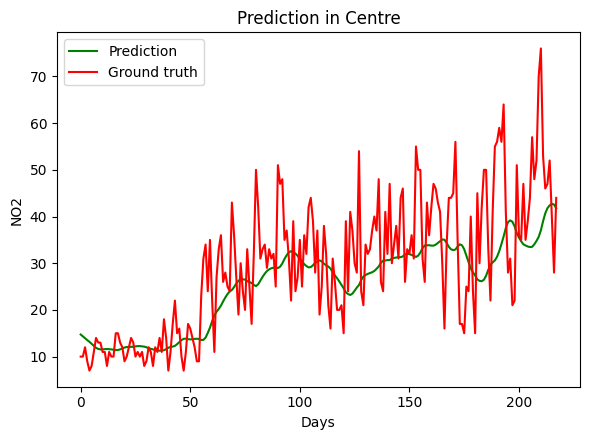

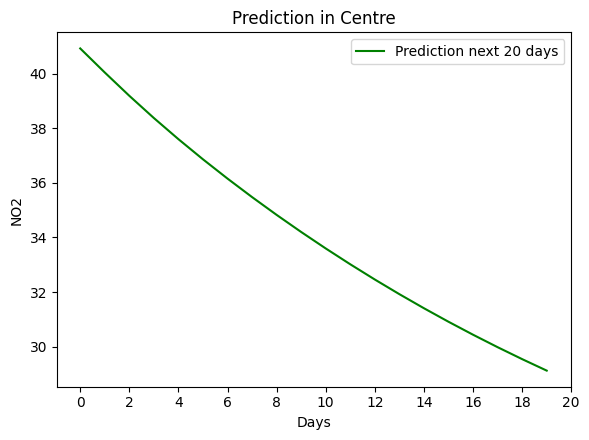

Root mean square error: 0.0871


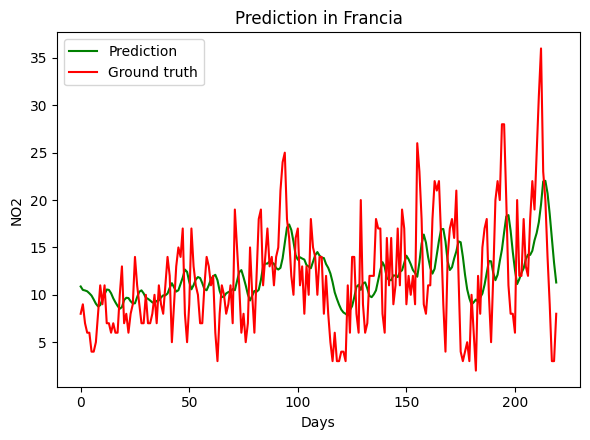

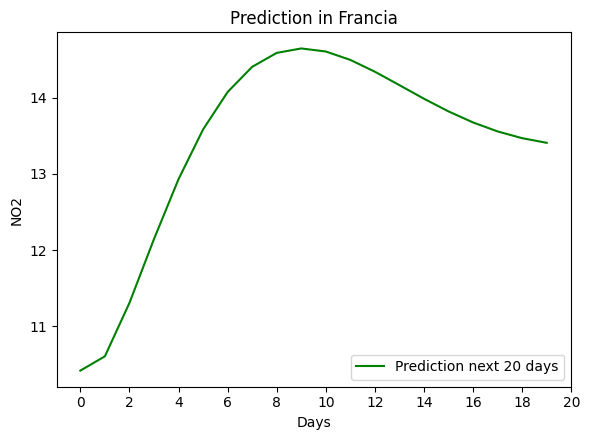

Root mean square error: 0.2583


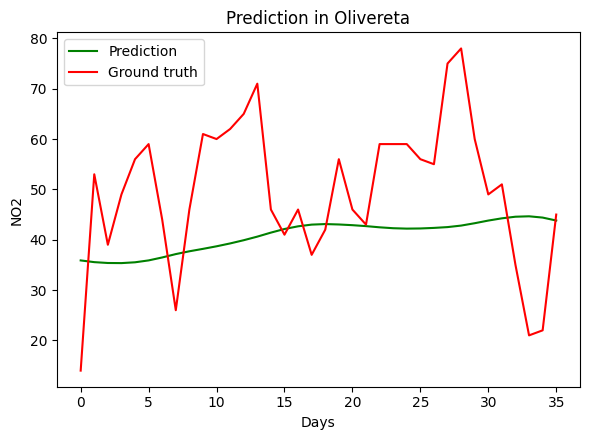

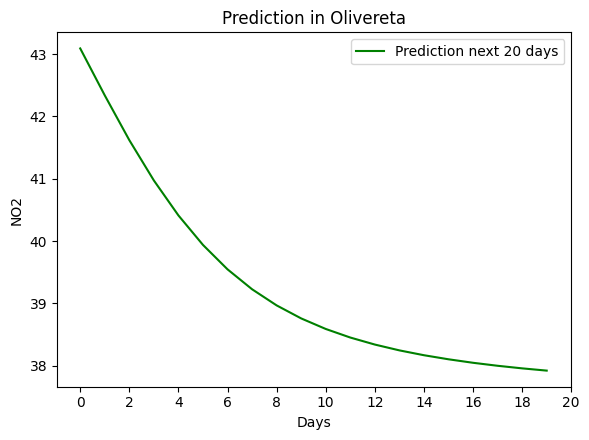

Root mean square error: 0.1484


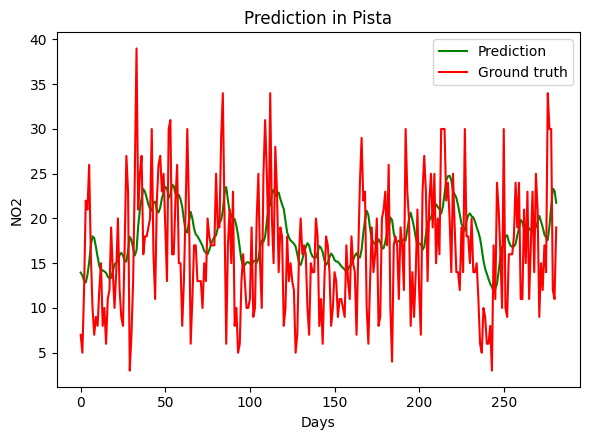

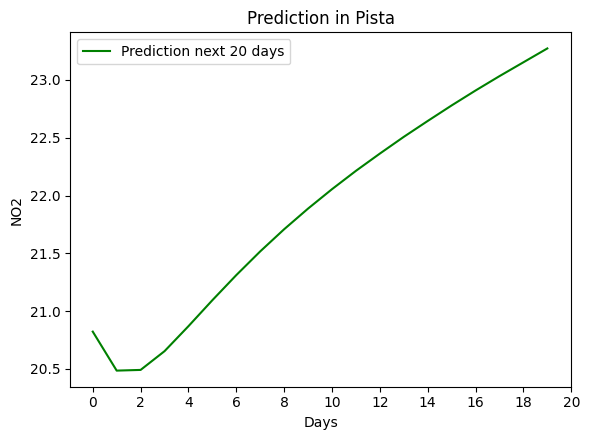

Root mean square error: 0.0825


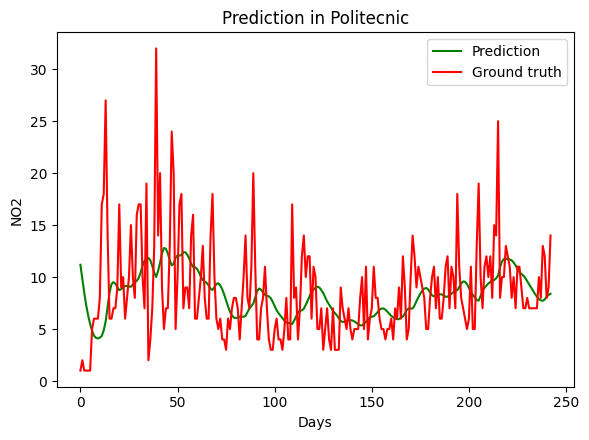

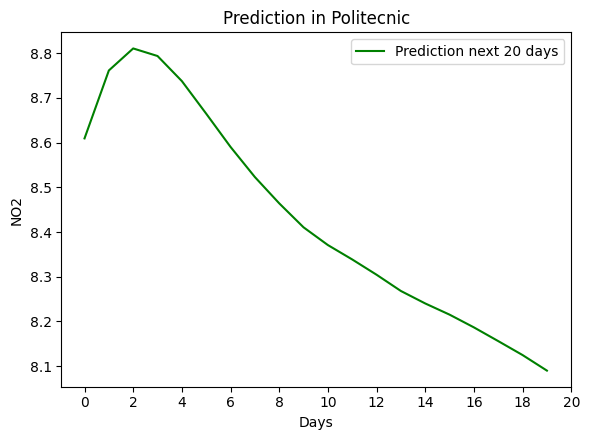

Root mean square error: 0.2673


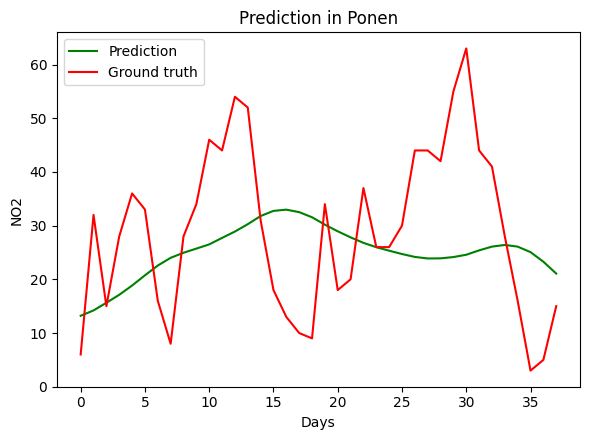

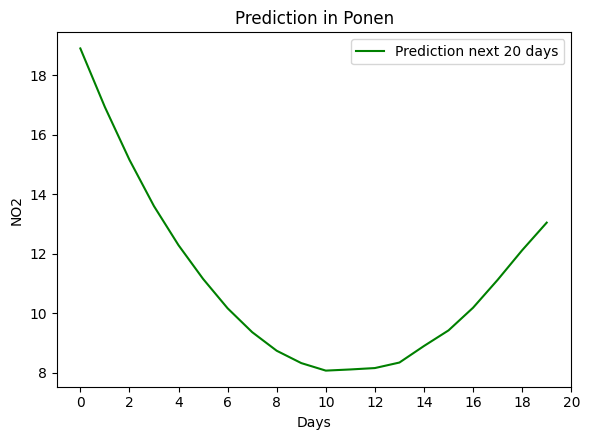

Root mean square error: 0.1533


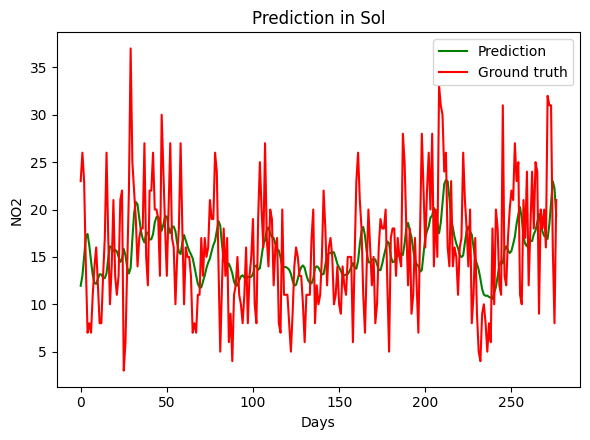

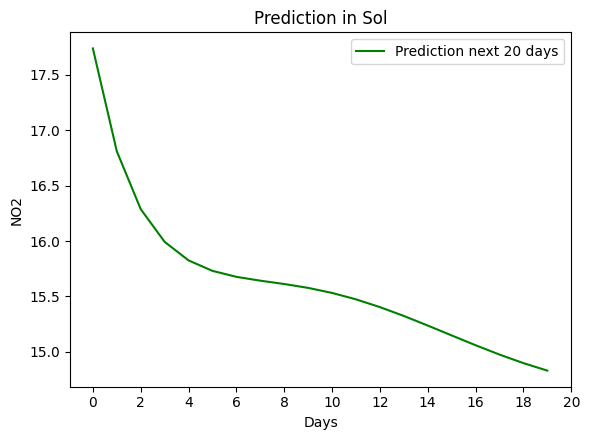

Root mean square error: 0.2538


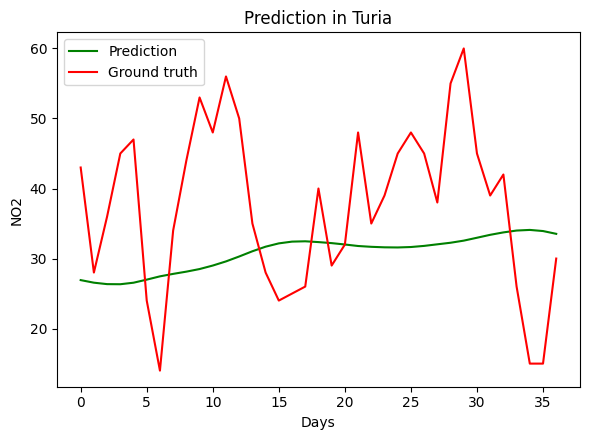

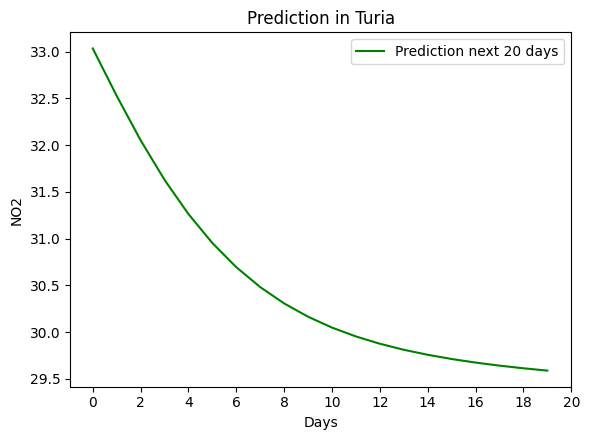

Root mean square error: 0.2592


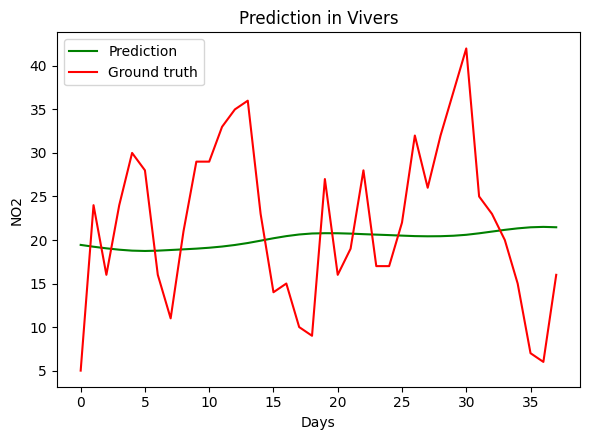

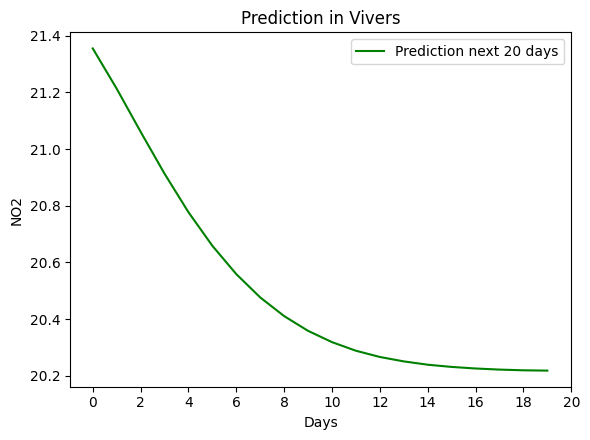

Root mean square error: 0.0818


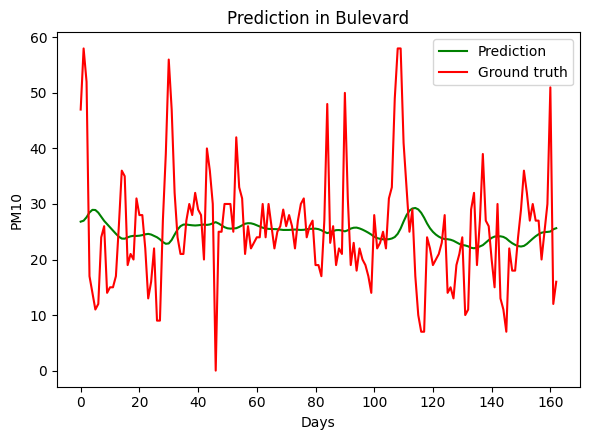

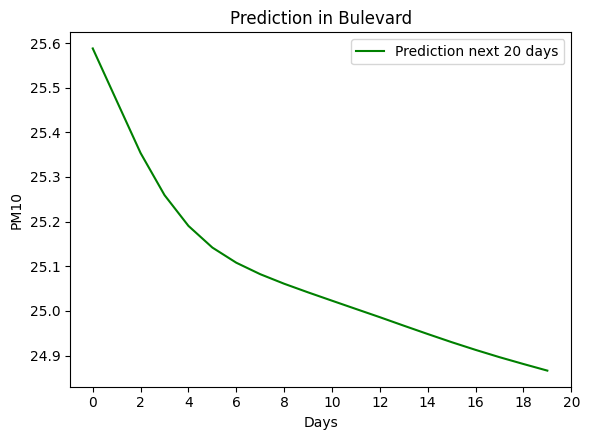

Root mean square error: 0.1141


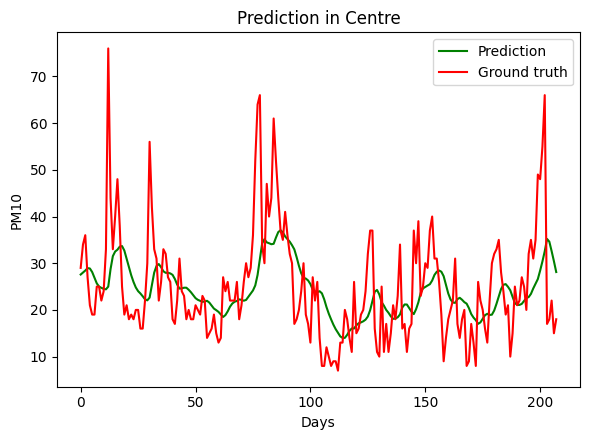

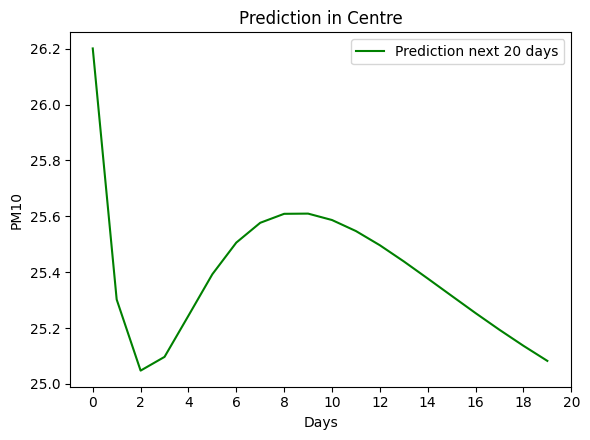

Root mean square error: 0.0599


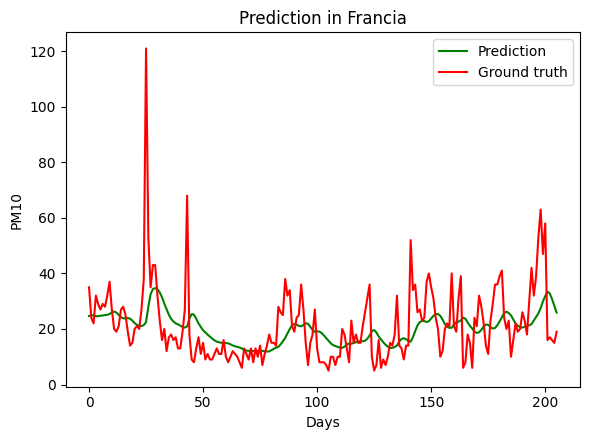

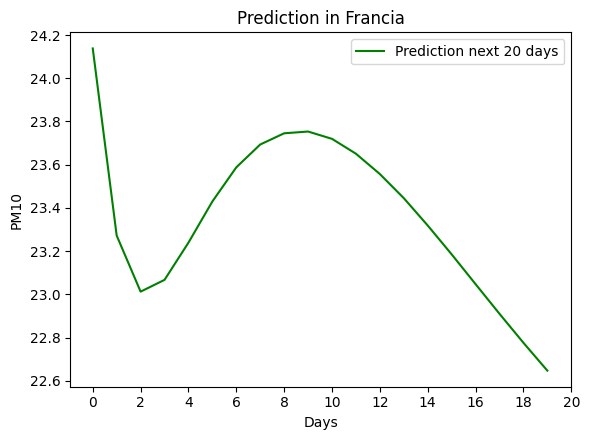

Root mean square error: 0.2238


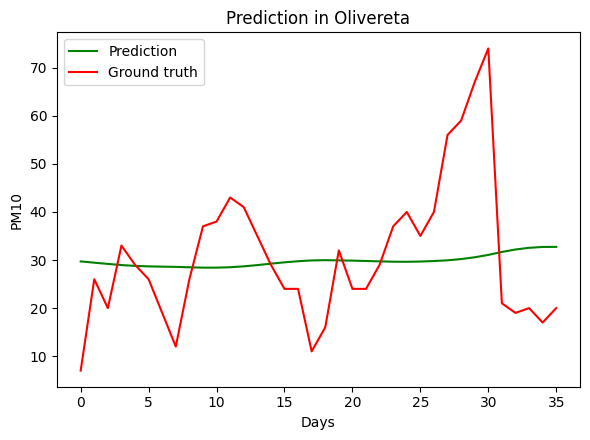

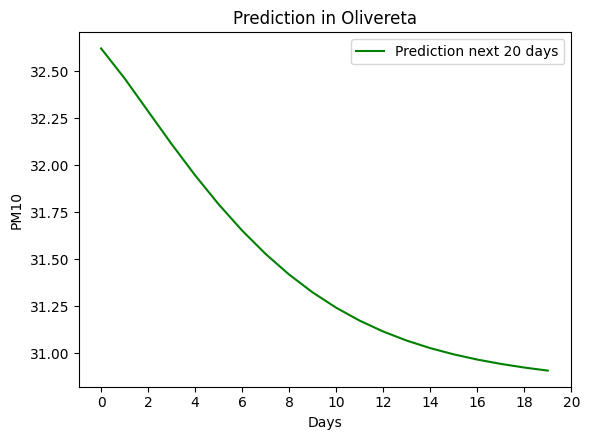

Root mean square error: 0.0988


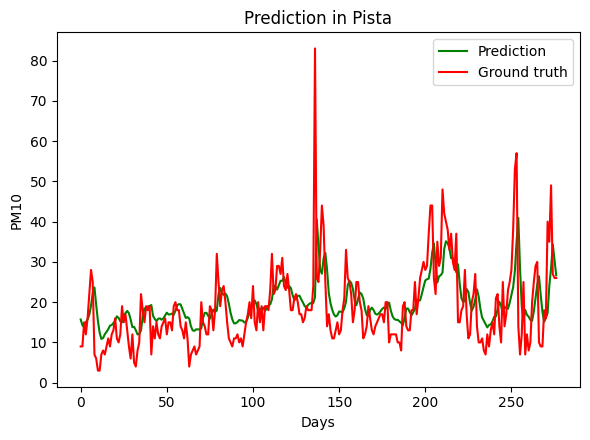

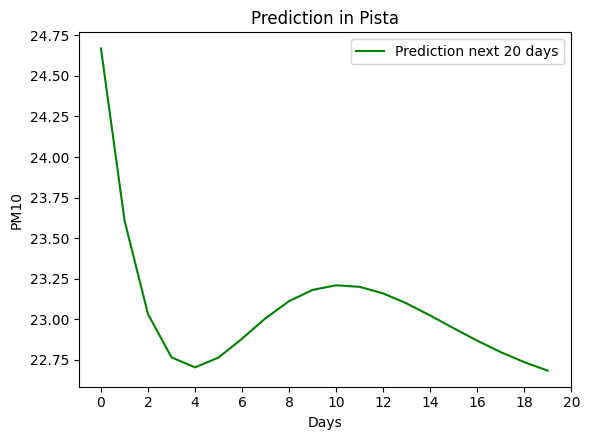

Root mean square error: 0.1187


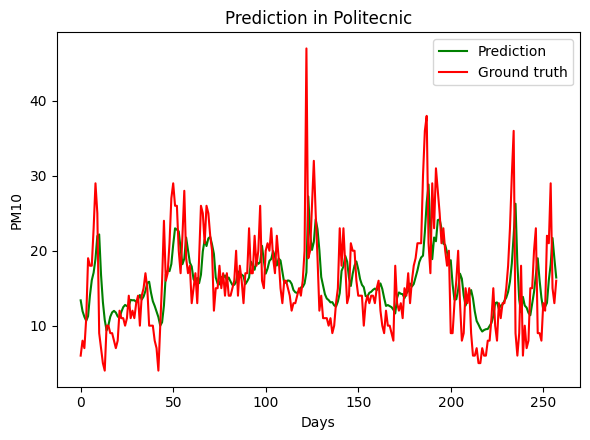

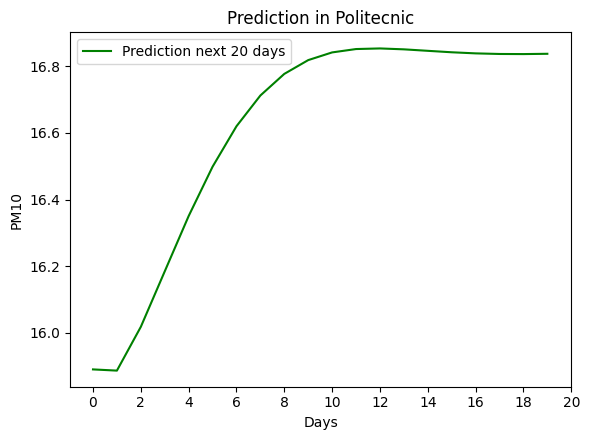

Root mean square error: 0.245


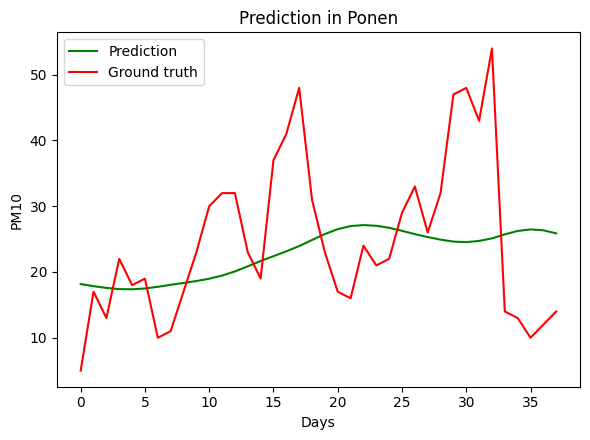

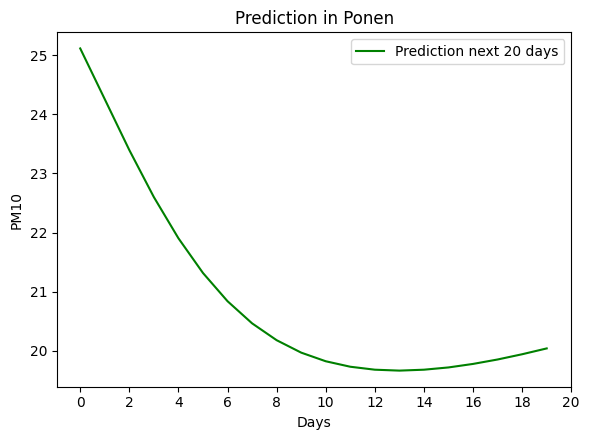

Root mean square error: 0.1116


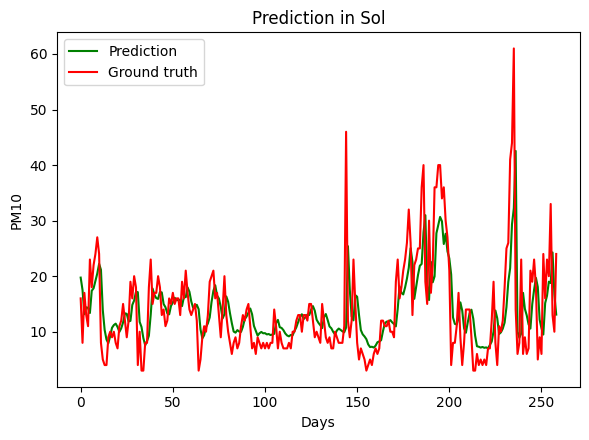

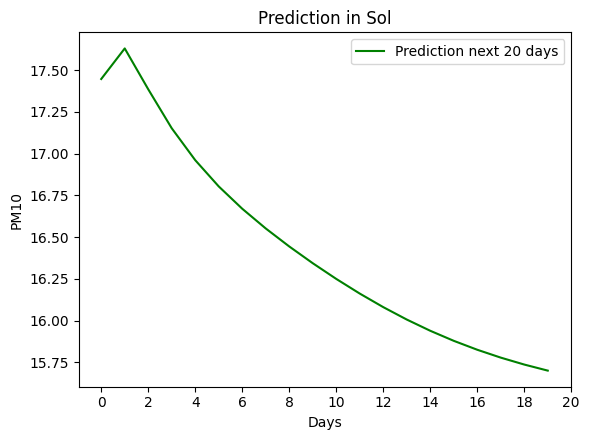

Root mean square error: 0.2166


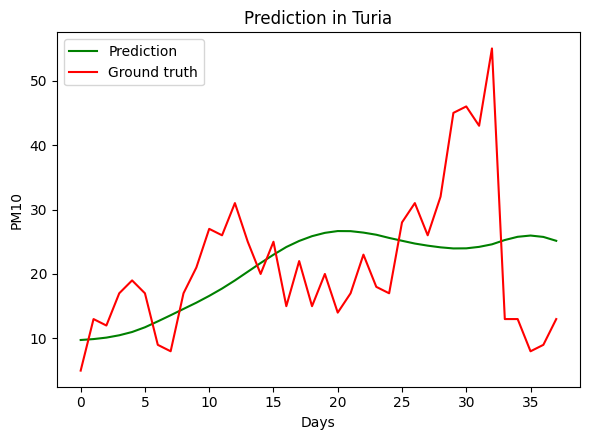

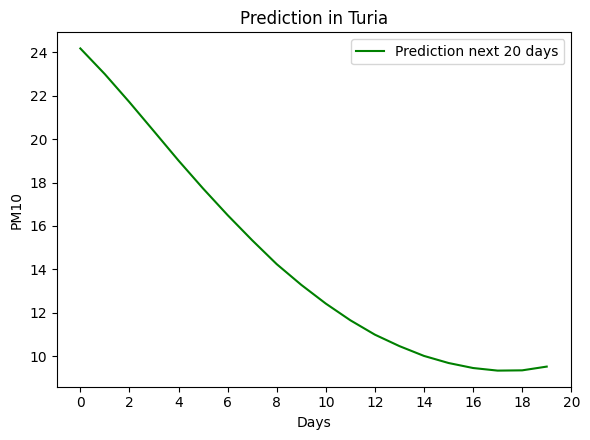

Root mean square error: 0.2749


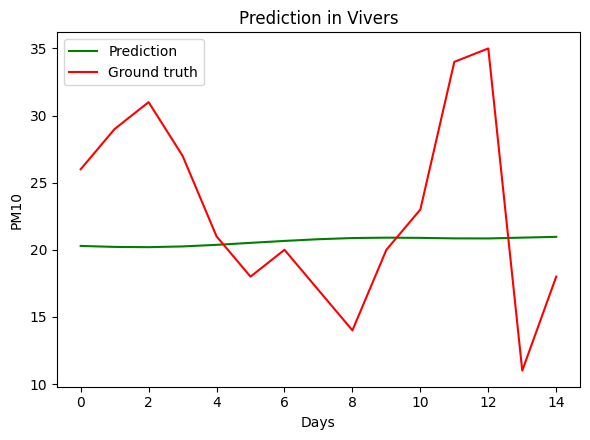

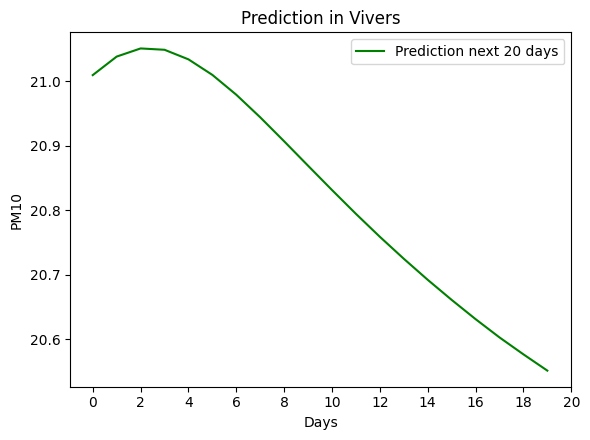

In [13]:
locations = ['Bulevard', 'Centre', 'Francia', 'Olivereta', 'Pista', 'Politecnic', 'Ponen', 'Sol', 'Turia', 'Vivers']
pollutants = ['NO2', 'PM10']
window_size = 50
days_predict = 20

for pollutant in pollutants:
  for location in locations:
    df = read_file(location, pollutant)
    X, Y, X_train, Y_train, X_test, Y_test, n_train, n_test, scaler, scaled_dataset = data_generating(df)
    model = model_LSTM(X_train)
    Y_pred = fit_model(X_train, Y_train, X_test, Y_test)
    Y_predicted, Y_tested = scale_back(Y_test, Y_pred)
    plot_graph(Y_tested, Y_predicted, location, pollutant)
    prediction = predict(X, Y)
    Y_predicted_future = scale_prediction(prediction)
    plot_prediction(location, pollutant, Y_predicted_future)